 # Homework 2 - Considering Bias in Data
Exploring bias in data using wikipedia articles on political figures from different countries.
Sources: Wikipedia articles, ORES, Country populations

## Step 1: Getting the Article and Population Data
Datasets used:
1. [politicians_by_country.SEPT.2022.csv](https://docs.google.com/spreadsheets/u/0/d/1Y4vSTYENgNE5KltqKZqnRQQBQZN5c8uKbSM4QTt8QGg/edit)
2. [population_by_country_2022.csv](https://docs.google.com/spreadsheets/u/0/d/1POuZDfA1sRooBq9e1RNukxyzHZZ-nQ2r6H5NcXhsMPU/edit)


### Dependencies and Setup

Python 3.10 is used to develop this project. Python package requirements are automatically installed when you execute the cells in the jupyter notebook.
Before proceeding with the execution of project in jupyter notebook, please replace the below line
```bash
  BASE_PATH = '/Users/sravan/PycharmProjects/DATA-512-HCD/data-512-homework_2'
```

In [ ]:
# Installing python packages for environment setup requirements
!python -m pip install -r requirements.txt

In [224]:
# importing python libraries
import os, json, time, datetime, urllib, re, requests
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

print(f'Current working directory: {os.getcwd()}')

Current working directory: /Users/sravan/PycharmProjects/DATA-512-HCD/data-512-homework_2


## Step 1.1 - Data Aquisition

We will be using the provided wikimedia API to fetch the pageinfo data related to the articles listed in the above mentioned excel file. We will then dump this data in the ``` intermediate_files``` folder. We will store all our data in two files

We will aslo store the intermediate data in the folder ```intermediate_files```. These files contain data related to the list of articles we are processing here and the csv formatted response data to enable us manually navigate the data in a tabular format and confirm our findings. 

data/politicians_by_country_SEPT.2022.csv - Wikipedia articles of politicians
data/population_by_country_2022.csv - Population informaton for regions and country

### Missing data and Exception handling

It is possible that few of the articles view data is missing in cases where an article is not available for the date we are looking against. In such cases we are printing the missing articles

In [225]:
# reading the politicien and population 
df_pol = pd.read_csv('data/politicians_by_country_SEPT.2022.csv')
df_pop = pd.read_csv('data/population_by_country_2022.csv')

In [226]:
df_pol.head()

,name,url,country
0,Shahjahan Noori,https://en.wikipedia.org/wiki/Shahjahan_Noori,Afghanistan
1,Abdul Ghafar Lakanwal,https://en.wikipedia.org/wiki/Abdul_Ghafar_Lak...,Afghanistan
2,Majah Ha Adrif,https://en.wikipedia.org/wiki/Majah_Ha_Adrif,Afghanistan
3,Haroon al-Afghani,https://en.wikipedia.org/wiki/Haroon_al-Afghani,Afghanistan
4,Tayyab Agha,https://en.wikipedia.org/wiki/Tayyab_Agha,Afghanistan


In [227]:
df_pop.head()

,Geography,Population (millions)
0,WORLD,7963.0
1,AFRICA,1419.0
2,NORTHERN AFRICA,251.0
3,Algeria,44.9
4,Egypt,103.5


## Validating and cleaning data to handle inconsistencies
Considerations: 
1. "You should be a little careful with the data. Crawling Wikipedia categories to identify relevant page subsets can result in misleading and/or duplicate category labels. Naturally, the data crawl attempted to resolve these, but not all may have been caught. You should document how you handle any data inconsistencies."
2. "The population_by_country_2022.csv contains some rows that provide cumulative regional population counts. These rows are distinguished by having ALL CAPS values in the 'geography' field (e.g. AFRICA, OCEANIA). These rows won't match the country values in politicians_by_country.SEPT.2022.csv, but you will want to retain some of them so that you can report coverage and quality by region as specified in the analysis section below."

In [228]:
df_pol.describe()

,name,url,country
count,7584,7584,7584
unique,7534,7534,185
top,Torokul Dzhanuzakov,https://en.wikipedia.org/wiki/Torokul_Dzhanuzakov,France
freq,4,4,251


In [229]:
# Finding and removing duplicates in politicians data
print(f'Politicians data shape: {df_pol.shape}')
print(f'Politicians data duplicate record count: {df_pol[df_pol.duplicated()].shape}')
print(f'Politicians data duplicates (based on article url only) count: {df_pol[df_pol.duplicated(subset=["url"])].shape}')


Politicians data shape: (7584, 3)
Politicians data duplicate record count: (2, 3)
Politicians data duplicates (based on article url only) count: (50, 3)


In [230]:
df_pop.describe()

,Population (millions)
count,233.000000
mean,134.913305
std,648.628406
min,0.000000
25%,1.800000
50%,9.700000
75%,44.000000
max,7963.000000


In [231]:
df_pop[df_pop['Population (millions)'] == 0]

,Geography,Population (millions)
183,Liechtenstein,0.0
185,Monaco,0.0
211,San Marino,0.0
223,Nauru,0.0
226,Palau,0.0
231,Tuvalu,0.0


### Observations from the above statististics
1. The politicians data has about 50 duplicate articles but this might be a valid condition as there are articles from past years about politicians who belong to more than one country
2. There a 2 dupliate records that we will be removing
3. There are few countries with 0 population. This might be a valid case as all the population information that we have is in millions. We will proceed with this data as is and remove them as required in our further analysis.

In [232]:
# Considering only the last entry from the politicians data to eliminate duplicates
df_pol = df_pol[-df_pol.duplicated()]

# Politicians data post clean up
print(f'Politicians data shape: {df_pol.shape}')
print(f'Politicians data duplicate record count: {df_pol[df_pol.duplicated()].shape[0]}')


Politicians data shape: (7582, 3)
Politicians data duplicate record count: 0


In [233]:
# Handling regional populations in population data
df_pop['Region'] = np.where(df_pop['Geography'].str.isupper(), df_pop['Geography'], None)
df_pop.Region.ffill(inplace=True)
df_pop = df_pop[-df_pop['Geography'].str.isupper()].reset_index().drop(columns=['index'])
df_pop.head()

,Geography,Population (millions),Region
0,Algeria,44.9,NORTHERN AFRICA
1,Egypt,103.5,NORTHERN AFRICA
2,Libya,6.8,NORTHERN AFRICA
3,Morocco,36.7,NORTHERN AFRICA
4,Sudan,46.9,NORTHERN AFRICA


## Step 2: Getting Article Quality Predictions
Now you need to get the predicted quality scores for each article in the Wikipedia dataset. We're using a machine learning system called ORES. This was originally an acronym for "Objective Revision Evaluation Service" but was simply renamed “ORES”. ORES is a machine learning tool that can provide estimates of Wikipedia article quality. The article quality estimates are, from best to worst:
1. FA - Featured article
2. GA - Good article
3. B - B-class article
4. C - C-class article
5. Start - Start-class article
6. Stub - Stub-class article


### Procedure
a) read each line of politicians_by_country.SEPT.2022.csv <br>
b) make a page info request to get the current page revision <br>
c) make an ORES request using the page title and current revision id. <br>


### 2.1 Getting the page information

In [234]:
ARTICLE_TITLES = df_pol['name']
# The basic English Wikipedia API endpoint
API_ENWIKIPEDIA_ENDPOINT = "https://en.wikipedia.org/w/api.php"

# We'll assume that there needs to be some throttling for these requests - we should always be nice to a free data resource
API_LATENCY_ASSUMED = 0.002       # Assuming roughly 2ms latency on the API and network
API_THROTTLE_WAIT = (1.0/100.0) - API_LATENCY_ASSUMED

# When making automated requests we should include something that is unique to the person making the request
# This should include an email - your UW email would be good to put in there
REQUEST_HEADERS = {
    'User-Agent': '<sravankr@uw.edu>, University of Washington, MSDS DATA 512 - AUTUMN 2022',
}

# This is a string of additional page properties that can be returned see the Info documentation for
# what can be included. If you don't want any this can simply be the empty string
PAGEINFO_EXTENDED_PROPERTIES = "talkid|url|watched|watchers"
#PAGEINFO_EXTENDED_PROPERTIES = ""

# This template lists the basic parameters for making this
PAGEINFO_PARAMS_TEMPLATE = {
    "action": "query",
    "format": "json",
    "titles": "",           # to simplify this should be a single page title at a time
    "prop": "info",
    "inprop": PAGEINFO_EXTENDED_PROPERTIES
}

# requesting page info for each article
def request_pageinfo_per_article(article_title = None, 
                                 endpoint_url = API_ENWIKIPEDIA_ENDPOINT, 
                                 request_template = PAGEINFO_PARAMS_TEMPLATE,
                                 headers = REQUEST_HEADERS):
    #global output
    # Make sure we have an article title
    if not article_title: return None
    
    request_template['titles'] = article_title   
    # make the request
    try:
        # we'll wait first, to make sure we don't exceed the limit in the situation where an exception
        # occurs during the request processing - throttling is always a good practice with a free
        # data source like Wikipedia - or any other community sources
        if API_THROTTLE_WAIT > 0.0:
            time.sleep(API_THROTTLE_WAIT)
        response = requests.get(endpoint_url, headers=headers, params=request_template)
        json_response = response.json()
    except Exception as e:
        print(e)
        json_response = None
    return json_response['query']['pages']

In [235]:
page_infos = {}
missing_pages = []
for idx in range(0, len(ARTICLE_TITLES), 50):
    pages = request_pageinfo_per_article('|'.join(ARTICLE_TITLES[idx:idx+50]))
    
    keys = [key for key in pages.keys()]
    missing_pages.extend([pages.pop(key)['title'] for key in keys if int(key) < 0])
            
    page_infos.update(pages)
    
    if idx % 1000 == 0:
        print(f'Progress: {round(idx/len(ARTICLE_TITLES) * 100, 2)}%', end='\r')
print('Progress: 100%', end='\r')
with open('intermediate_data/page_info_responses.json', 'w') as f:
    json.dump(page_infos, f)
    print(f'Saved the file to {f.name}')
print('Article info is not available for the below titles:')
for article in missing_pages:
    print(article)

Saved the file to intermediate_data/page_info_responses.json
Article info is not available for the below titles:
Hopeson Adorye
Prince Ofosu Sefah
Harjit Kaur Talwandi
Abd al-Razzaq al-Hasani
Abiodun Abimbola Orekoya
Segun “Aeroland” Adewale
Roman Konoplev
Nhlanhla “Lux” Dlamini


In [236]:
from collections import namedtuple

article_info = namedtuple('article_info', 'article revid')

with open('intermediate_data/page_info_responses.json') as f:
    articles_data = json.load(f)

df_art_revid = pd.DataFrame([article_info(val['title'], str(val['lastrevid']))
                             for key,val in articles_data.items()])
df_art_revid.head()

,article,revid
0,Abas Basir,1098419766
1,Abdul Baqi Turkistani,889226470
2,Abdul Ghafar Lakanwal,943562276
3,Abdul Ghani Ghani,1072441893
4,Abdul Malik Hamwar,1100874645


In [237]:
df_pol_revid = pd.merge(df_art_revid, df_pol, left_on='article', right_on='name', how='left').drop(columns=['name', 'url'])
df_pol_revid.head()

,article,revid,country
0,Abas Basir,1098419766,Afghanistan
1,Abdul Baqi Turkistani,889226470,Afghanistan
2,Abdul Ghafar Lakanwal,943562276,Afghanistan
3,Abdul Ghani Ghani,1072441893,Afghanistan
4,Abdul Malik Hamwar,1100874645,Afghanistan


### 2.2 Getting the page information

In [238]:
# The current ORES API endpoint
API_ORES_SCORE_ENDPOINT = "https://ores.wikimedia.org/v3"
# A template for mapping to the URL
API_ORES_SCORE_PARAMS = "/scores/{context}/?models={model}&revids={revids}"

# Use some delays so that we do not hammer the API with our requests
API_LATENCY_ASSUMED = 0.002       # Assuming roughly 2ms latency on the API and network
API_THROTTLE_WAIT = (1.0/100.0) - API_LATENCY_ASSUMED

# When making automated requests we should include something that is unique to the person making the request
# This should include an email - your UW email would be good to put in there
REQUEST_HEADERS = {
    'User-Agent': '<karasth@uw.edu>, University of Washington, MSDS DATA 512 - AUTUMN 2022'
}

# This template lists the basic parameters for making an ORES request
ORES_PARAMS_TEMPLATE = {
    "context": "enwiki",        # which WMF project for the specified revid
    "revid" : "",               # the revision to be scored - this will probably change each call
    "model": "articlequality"   # the AI/ML scoring model to apply to the reviewion
}


def request_ores_score_per_article(article_revid = None, 
                                   endpoint_url = API_ORES_SCORE_ENDPOINT, 
                                   endpoint_params = API_ORES_SCORE_PARAMS, 
                                   request_template = ORES_PARAMS_TEMPLATE,
                                   headers = REQUEST_HEADERS,
                                   features=False):
    # Make sure we have an article revision id
    if not article_revid: return None
    
    # set the revision id into the template
    request_template['revids'] = article_revid
    
    # now, create a request URL by combining the endpoint_url with the parameters for the request
    request_url = endpoint_url+endpoint_params.format(**request_template)
    
    # the features used by the ML model can sometimes be returned as well as scores
    if features:
        request_url = request_url+"?features=true"
    
    # make the request
    try:
        # we'll wait first, to make sure we don't exceed the limit in the situation where an exception
        # occurs during the request processing - throttling is always a good practice with a free
        # data source like ORES - or other community sources
        if API_THROTTLE_WAIT > 0.0:
            time.sleep(API_THROTTLE_WAIT)
        response = requests.get(request_url, headers=headers)
        json_response = response.json()
    except Exception as e:
        print(e)
        json_response = None
    return json_response['enwiki']['scores']


In [239]:
page_ores = {}
missing_ores = []
for idx in range(0, len(df_pol_revid['revid']), 50):
    pages = request_ores_score_per_article('|'.join(df_pol_revid['revid'].iloc[idx:idx+50]))
    
    keys = [key for key in pages.keys()]
    missing_ores.extend([pages.pop(key) for key in keys if int(key) < 0])
            
    page_ores.update(pages)
    
    if idx % 1000 == 0:
        print(f'Progress: {round(idx/len(df_pol_revid["revid"]) * 100, 2)}%', end='\r')
        
print('Progress: 100%', end='\r')
with open('intermediate_data/page_ores_responses.json', 'w') as f:
    json.dump(page_ores, f)
    print(f'Saved the file to {f.name}')
    
print('Article ores is not available for the below titles:')
for article in missing_ores:
    print(article)

Saved the file to intermediate_data/page_ores_responses.json
Article ores is not available for the below titles:


In [240]:
from collections import namedtuple

article_ores = namedtuple('article_ores', 'revid ores')

with open('intermediate_data/page_ores_responses.json') as f:
    ores_data = json.load(f)

df_revid_ores = pd.DataFrame([article_ores(key, val['articlequality']['score']['prediction'])
                             for key,val in ores_data.items()])
df_revid_ores.head()

,revid,ores
0,1013838830,Stub
1,1033383351,Stub
2,1038918070,Start
3,1041460606,B
4,1060707209,Start


In [241]:
df_art_ores = pd.merge(df_pol_revid, df_revid_ores, on='revid', how='right') \
                .rename(columns={'article':'article_title', 
                                 'revid': 'revision_id',
                                 'ores':'article_quality'})
df_art_ores.head()

,article_title,revision_id,country,article_quality
0,Mohammad Asim Asim,1013838830,Afghanistan,Stub
1,Aimal Faizi,1033383351,Afghanistan,Stub
2,Mohammad Sarwar Ahmedzai,1038918070,Afghanistan,Start
3,Sharif Ghalib,1041460606,Afghanistan,B
4,Bashir Ahmad Bezan,1060707209,Afghanistan,Start


## Step 3: Combining the Datasets

In [242]:
df_pop_pol = pd.merge(df_pop, df_art_ores, how='outer', left_on='Geography', right_on='country')
df_pop_pol.head()

,Geography,Population (millions),Region,article_title,revision_id,country,article_quality
0,Algeria,44.9,NORTHERN AFRICA,Mohamed Elias Mesli,1009461580,Algeria,Stub
1,Algeria,44.9,NORTHERN AFRICA,Fatiha Serour,1019766063,Algeria,Start
2,Algeria,44.9,NORTHERN AFRICA,Mokhtar Meherzi,1028900891,Algeria,Stub
3,Algeria,44.9,NORTHERN AFRICA,Abdenour Keramane,1028900906,Algeria,Stub
4,Algeria,44.9,NORTHERN AFRICA,Azzedine Mihoubi,1031600815,Algeria,Start


In [243]:
no_match_in_pop = df_pop_pol[df_pop_pol['Geography'].isna()]['country'].unique()
no_match_in_pop

array(['Korean'], dtype=object)

In [244]:
no_match_in_pol = df_pop_pol[df_pop_pol['country'].isna()]['Geography'].unique()
no_match_in_pol

array(['Western Sahara', 'Mauritius', 'Mayotte', 'Reunion',
       'Sao Tome and Principe', 'eSwatini', 'Canada', 'United States',
       'Curacao', 'Guadeloupe', 'Martinique', 'Puerto Rico',
       'French Guiana', 'Brunei', 'Philippines', 'China,  Hong Kong SAR',
       'China,  Macao SAR', 'Ireland', 'United Kingdom', 'Australia',
       'French Polynesia', 'Guam', 'Kiribati', 'New Caledonia',
       'New Zealand'], dtype=object)

In [245]:
missing_countries = list(np.sort(np.append(no_match_in_pop, no_match_in_pol)))

with open('wp_countries-no_match.txt', 'w') as f:
    for line in missing_countries:
        f.write(line + '\n')

missing_countries

['Australia',
 'Brunei',
 'Canada',
 'China,  Hong Kong SAR',
 'China,  Macao SAR',
 'Curacao',
 'French Guiana',
 'French Polynesia',
 'Guadeloupe',
 'Guam',
 'Ireland',
 'Kiribati',
 'Korean',
 'Martinique',
 'Mauritius',
 'Mayotte',
 'New Caledonia',
 'New Zealand',
 'Philippines',
 'Puerto Rico',
 'Reunion',
 'Sao Tome and Principe',
 'United Kingdom',
 'United States',
 'Western Sahara',
 'eSwatini']

In [246]:
# Remove records with no country match
df_pop_pol.dropna(inplace=True)

# Drop repetitive columns
df_pop_pol.drop(columns=['Geography'], inplace=True)

# Rename columns
df_pop_pol.rename(columns={'Population (millions)': 'population',
                           'Region': 'region'},
                  inplace=True)

# Reorder the columns
df_pop_pol = df_pop_pol[['country', 'region', 'population', 'article_title', 'revision_id', 'article_quality']]

# Saving the file
df_pop_pol.to_csv('wp_politicians_by_country.csv', index=False)

df_pop_pol.head()

,country,region,population,article_title,revision_id,article_quality
0,Algeria,NORTHERN AFRICA,44.9,Mohamed Elias Mesli,1009461580,Stub
1,Algeria,NORTHERN AFRICA,44.9,Fatiha Serour,1019766063,Start
2,Algeria,NORTHERN AFRICA,44.9,Mokhtar Meherzi,1028900891,Stub
3,Algeria,NORTHERN AFRICA,44.9,Abdenour Keramane,1028900906,Stub
4,Algeria,NORTHERN AFRICA,44.9,Azzedine Mihoubi,1031600815,Start


## Step 4: Analysis

In [247]:
df_percapita_arts = df_pop_pol.groupby('country', as_index=False).agg({'revision_id':['count'], 
                                                       'population':['mean']})
df_percapita_arts.columns = df_percapita_arts.columns.map('-'.join).str.strip('-')
df_percapita_arts.rename(columns={'revision_id-count': 'article_count', 
                                  'population-mean': 'population'},
                        inplace=True)
df_percapita_arts['percapita_articles'] = np.divide(df_percapita_arts['article_count'], 
                                                    df_percapita_arts['population'] * 1000000)
df_percapita_arts = df_percapita_arts[df_percapita_arts['percapita_articles'] != np.inf]
df_percapita_arts.head()

,country,article_count,population,percapita_articles
0,Afghanistan,118,41.1,2.871046e-06
1,Albania,83,2.8,2.964286e-05
2,Algeria,34,44.9,7.572383e-07
3,Andorra,10,0.1,1.000000e-04
4,Angola,42,35.6,1.179775e-06


In [248]:
df_percapita_hq_arts = df_pop_pol[df_pop_pol['article_quality'].isin(['FA', 'GA'])].groupby('country', as_index=False).agg({'revision_id':['count'], 
                                                       'population':['mean']})
df_percapita_hq_arts.columns = df_percapita_hq_arts.columns.map('-'.join).str.strip('-')
df_percapita_hq_arts.rename(columns={'revision_id-count': 'article_count', 
                                  'population-mean': 'population'},
                        inplace=True)
df_percapita_hq_arts['percapita_articles'] = np.divide(df_percapita_hq_arts['article_count'], 
                                                       df_percapita_hq_arts['population'] * 1000000)
df_percapita_hq_arts = df_percapita_hq_arts[df_percapita_hq_arts['percapita_articles'] != np.inf]
df_percapita_hq_arts.head()

,country,article_count,population,percapita_articles
0,Afghanistan,6,41.1,1.459854e-07
1,Albania,6,2.8,2.142857e-06
2,Andorra,2,0.1,2.000000e-05
3,Armenia,1,3.0,3.333333e-07
4,Azerbaijan,1,10.2,9.803922e-08


In [249]:
df_pc_reg_arts = df_pop_pol.groupby('region', as_index=False).agg({'revision_id':['count'], 
                                                       'population':['mean']})
df_pc_reg_arts.columns = df_pc_reg_arts.columns.map('-'.join).str.strip('-')
df_pc_reg_arts.rename(columns={'revision_id-count': 'article_count', 
                                  'population-mean': 'population'},
                        inplace=True)
df_pc_reg_arts['percapita_articles'] = np.divide(df_pc_reg_arts['article_count'], 
                                                    df_pc_reg_arts['population'] * 1000000)
df_pc_reg_arts = df_pc_reg_arts[df_pc_reg_arts['percapita_articles'] != np.inf]
df_pc_reg_arts.head()

,region,article_count,population,percapita_articles
0,CARIBBEAN,201,6.166667,0.000033
1,CENTRAL AMERICA,195,9.003590,0.000022
2,CENTRAL ASIA,106,16.871698,0.000006
3,EAST ASIA,246,88.576423,0.000003
4,EASTERN AFRICA,648,29.371605,0.000022


In [250]:
df_pc_hq_reg_arts = df_pop_pol[df_pop_pol['article_quality'].isin(['FA', 'GA'])].groupby('region', as_index=False).agg({'revision_id':['count'], 
                                                       'population':['mean']})
df_pc_hq_reg_arts.columns = df_pc_hq_reg_arts.columns.map('-'.join).str.strip('-')
df_pc_hq_reg_arts.rename(columns={'revision_id-count': 'article_count', 
                                  'population-mean': 'population'},
                        inplace=True)
df_pc_hq_reg_arts['percapita_articles'] = np.divide(df_pc_hq_reg_arts['article_count'], 
                                                    df_pc_hq_reg_arts['population'] * 1000000)
df_pc_hq_reg_arts = df_pc_hq_reg_arts[df_pc_hq_reg_arts['percapita_articles'] != np.inf]
df_pc_hq_reg_arts.head()

,region,article_count,population,percapita_articles
0,CARIBBEAN,8,11.200000,7.142857e-07
1,CENTRAL AMERICA,10,10.220000,9.784736e-07
2,CENTRAL ASIA,3,15.066667,1.991150e-07
3,EAST ASIA,16,59.168750,2.704130e-07
4,EASTERN AFRICA,15,43.560000,3.443526e-07


## Step 5: Results

1. Top 10 countries by coverage: The 10 countries with the highest total articles per capita (in descending order) .

In [251]:
df_pc_arts_top10 = df_percapita_arts.sort_values(by='percapita_articles', ascending=False) \
                                    .reset_index() \
                                    .drop(columns=['index']).iloc[:10]
df_pc_arts_top10.head(10)

,country,article_count,population,percapita_articles
0,Antigua and Barbuda,17,0.1,0.000170
1,Federated States of Micronesia,13,0.1,0.000130
2,Andorra,10,0.1,0.000100
3,Barbados,28,0.3,0.000093
4,Marshall Islands,9,0.1,0.000090
5,Montenegro,36,0.6,0.000060
6,Seychelles,6,0.1,0.000060
7,Luxembourg,37,0.7,0.000053
8,Bhutan,41,0.8,0.000051
9,Grenada,5,0.1,0.000050


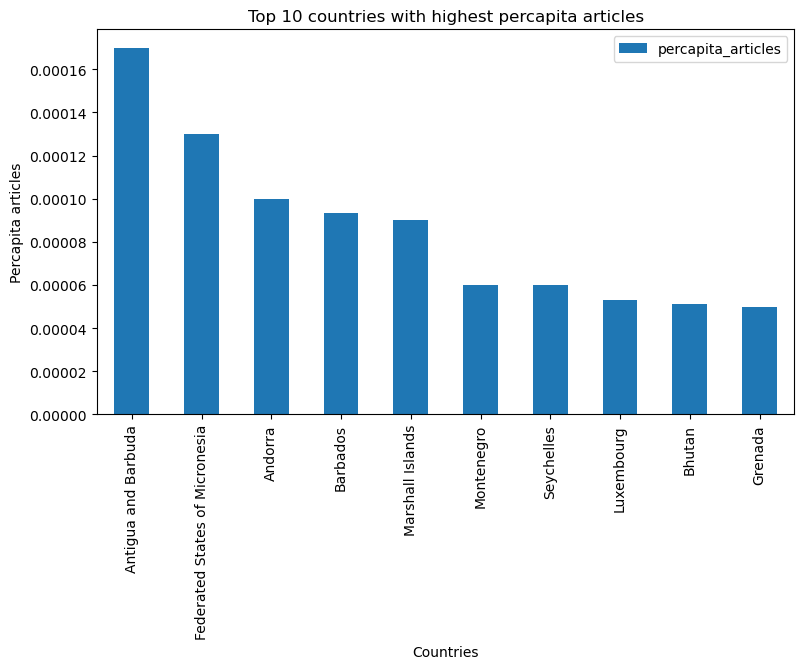

In [252]:
df_pc_arts_top10.plot.bar(x='country', y='percapita_articles',
                          xlabel='Countries',
                          ylabel='Percapita articles', 
                          title='Top 10 countries with highest percapita articles',
                          figsize=(9,5))
plt.savefig('figures/top10_countries_by_coverage.png', bbox_inches='tight')

In [253]:
df_pc_arts_bot10 = df_percapita_arts.sort_values(by='percapita_articles') \
                                    .reset_index() \
                                    .drop(columns=['index']).iloc[:10]
df_pc_arts_bot10.head(10)

,country,article_count,population,percapita_articles
0,China,2,1436.6,1.392176e-09
1,Mexico,1,127.5,7.843137e-09
2,Saudi Arabia,3,36.7,8.174387e-08
3,Romania,2,19.0,1.052632e-07
4,India,178,1417.2,1.255998e-07
5,Sri Lanka,3,22.4,1.339286e-07
6,Egypt,14,103.5,1.352657e-07
7,Ethiopia,25,123.4,2.025932e-07
8,Taiwan,5,23.2,2.155172e-07
9,Vietnam,27,99.4,2.716298e-07


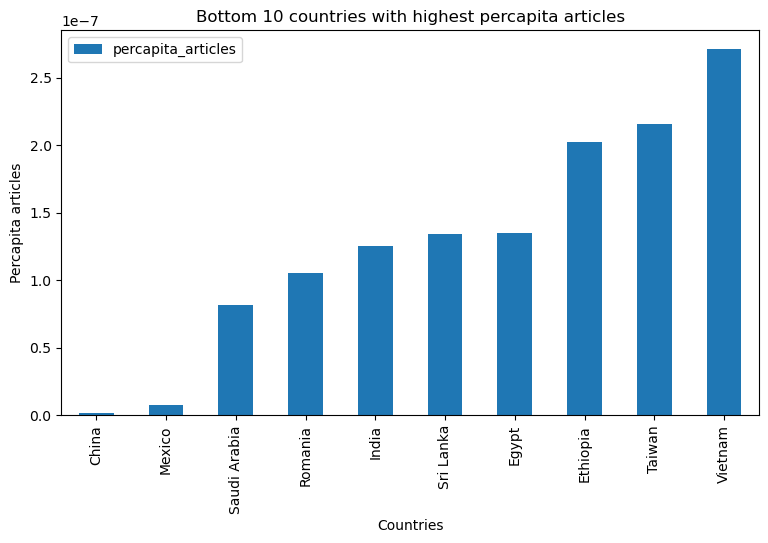

In [254]:
df_pc_arts_bot10.plot.bar(x='country', y='percapita_articles',
                          xlabel='Countries',
                          ylabel='Percapita articles', 
                          title='Bottom 10 countries with highest percapita articles',
                          figsize=(9,5))
plt.savefig('figures/bottom10_countries_by_coverage.png', bbox_inches='tight')

In [255]:
df_pc_hq_arts_top10 = df_percapita_hq_arts.sort_values(by='percapita_articles', ascending=False) \
                                    .reset_index() \
                                    .drop(columns=['index']).iloc[:10]
df_pc_hq_arts_top10.head(10)

,country,article_count,population,percapita_articles
0,Andorra,2,0.1,2.000000e-05
1,Montenegro,3,0.6,5.000000e-06
2,Albania,6,2.8,2.142857e-06
3,Suriname,1,0.6,1.666667e-06
4,Bosnia-Herzegovina,5,3.4,1.470588e-06
5,Lithuania,3,2.8,1.071429e-06
6,Croatia,4,3.8,1.052632e-06
7,Slovenia,2,2.1,9.523810e-07
8,Palestinian Territory,5,5.4,9.259259e-07
9,Gabon,2,2.4,8.333333e-07


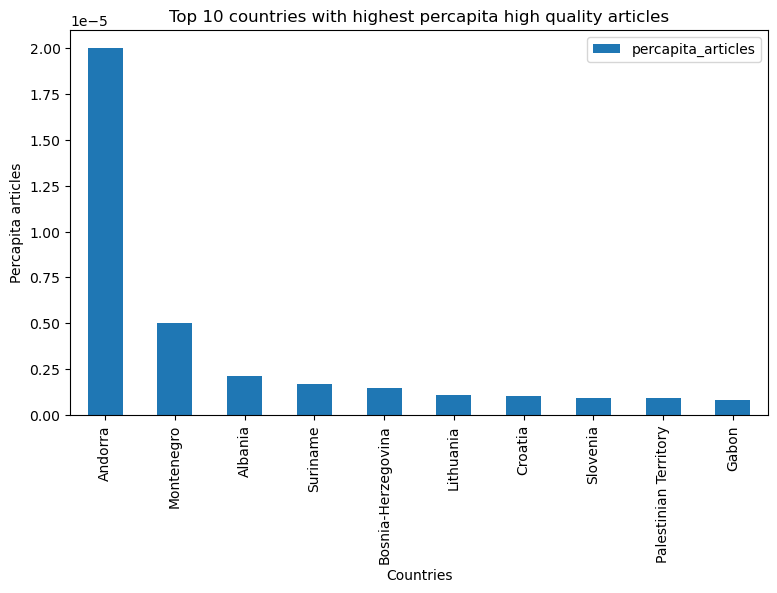

In [256]:
df_pc_hq_arts_top10.plot.bar(x='country', y='percapita_articles',
                          xlabel='Countries',
                          ylabel='Percapita articles', 
                          title='Top 10 countries with highest percapita high quality articles',
                          figsize=(9,5))
plt.savefig('figures/top10_highquality_countries_by_coverage.png', bbox_inches='tight')

In [257]:
df_pc_hq_arts_bot10 = df_percapita_hq_arts.sort_values(by='percapita_articles') \
                                    .reset_index() \
                                    .drop(columns=['index']).iloc[:10]
df_pc_hq_arts_bot10.head(10)

,country,article_count,population,percapita_articles
0,India,6,1417.2,4.233700e-09
1,Thailand,1,66.8,1.497006e-08
2,Japan,2,124.9,1.601281e-08
3,Nigeria,4,218.5,1.830664e-08
4,Vietnam,2,99.4,2.012072e-08
5,Colombia,1,49.1,2.036660e-08
6,Uganda,1,47.2,2.118644e-08
7,Pakistan,5,235.8,2.120441e-08
8,Sudan,1,46.9,2.132196e-08
9,Iran,2,88.6,2.257336e-08


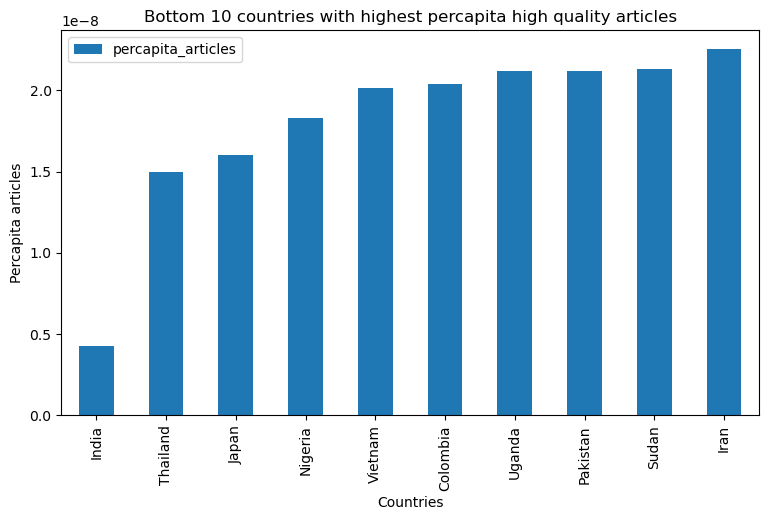

In [258]:
df_pc_hq_arts_bot10.plot.bar(x='country', y='percapita_articles',
                          xlabel='Countries',
                          ylabel='Percapita articles', 
                          title='Bottom 10 countries with highest percapita high quality articles',
                          figsize=(9,5))
plt.savefig('figures/bottom10_highquality_countries_by_coverage.png', bbox_inches='tight')

In [259]:
df_reg_pc_arts = df_pc_reg_arts.sort_values(by='percapita_articles', ascending=False) \
                                    .reset_index() \
                                    .drop(columns=['index'])
df_reg_pc_arts.head(100)

,region,article_count,population,percapita_articles
0,OCEANIA,86,1.280233,0.000067
1,NORTHERN EUROPE,262,5.146565,0.000051
2,SOUTHERN EUROPE,890,21.847865,0.000041
3,CARIBBEAN,201,6.166667,0.000033
4,WESTERN ASIA,686,22.642274,0.000030
5,EASTERN AFRICA,648,29.371605,0.000022
6,CENTRAL AMERICA,195,9.003590,0.000022
7,WESTERN EUROPE,699,43.238913,0.000016
8,EASTERN EUROPE,735,50.573878,0.000015
9,SOUTH AMERICA,577,54.480069,0.000011


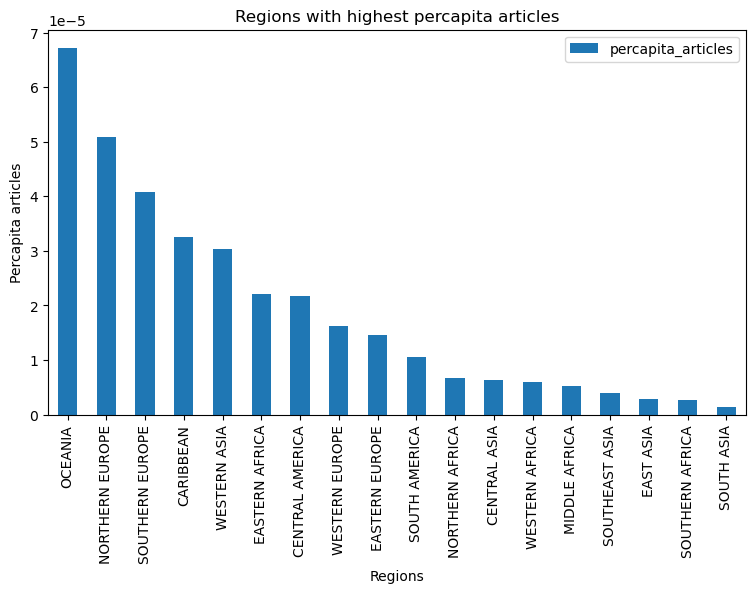

In [260]:
df_reg_pc_arts.plot.bar(x='region', y='percapita_articles',
                          xlabel='Regions',
                          ylabel='Percapita articles', 
                          title='Regions with highest percapita articles',
                          figsize=(9,5))
plt.savefig('figures/article_regions_by_coverage.png', bbox_inches='tight')

In [261]:
df_reg_pc_hq_arts = df_pc_hq_reg_arts.sort_values(by='percapita_articles', ascending=False) \
                                    .reset_index() \
                                    .drop(columns=['index'])
df_reg_pc_hq_arts.head(100)

,region,article_count,population,percapita_articles
0,SOUTHERN EUROPE,46,19.795652,2.323743e-06
1,WESTERN ASIA,28,19.242857,1.455085e-06
2,NORTHERN EUROPE,8,5.825000,1.373391e-06
3,CENTRAL AMERICA,10,10.220000,9.784736e-07
4,CARIBBEAN,8,11.200000,7.142857e-07
5,MIDDLE AFRICA,5,8.780000,5.694761e-07
6,SOUTH AMERICA,13,23.253846,5.590473e-07
7,EASTERN EUROPE,38,75.057895,5.062759e-07
8,OCEANIA,2,4.650000,4.301075e-07
9,WESTERN EUROPE,22,52.186364,4.215661e-07


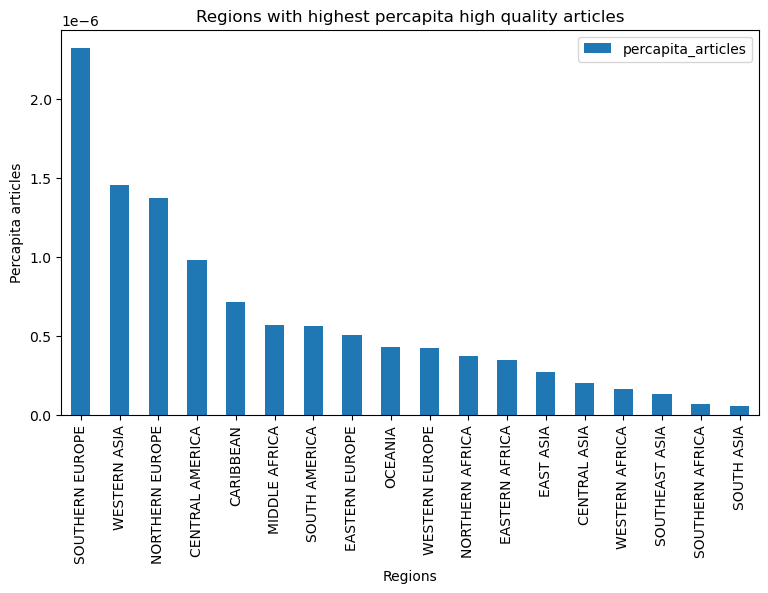

In [262]:
df_reg_pc_hq_arts.plot.bar(x='region', y='percapita_articles',
                          xlabel='Regions',
                          ylabel='Percapita articles', 
                          title='Regions with highest percapita high quality articles',
                          figsize=(9,5))
plt.savefig('figures/highquality_article_regions_by_coverage.png', bbox_inches='tight')